In [ ]:
! pip install langgraph

In [5]:
from langgraph.graph import StateGraph,START,END

# Sequential Workflow without LLM ----  BMI Calculator Example

## Define State

In [10]:
from typing import TypedDict

class BMIState(TypedDict):
    weight_kg: float
    height_m: float
    bmi: float
    category: str



## Create Nodes

In [12]:
def calculate_bmi(state: BMIState) -> BMIState:

    weight = state['weight_kg']
    height = state['height_m']

    bmi = weight/(height**2)

    state['bmi'] = round(bmi, 2)

    return state

In [13]:
def label_bmi(state:BMIState) ->BMIState:

  bmi = state['bmi']

  if bmi < 18.5:
      state["category"] = "Underweight"
  elif 18.5 <= bmi < 25:
      state["category"] = "Normal"
  elif 25 <= bmi < 30:
      state["category"] = "Overweight"
  else:
      state["category"] = "Obese"

  return state

## Define Graph

In [14]:
graph = StateGraph(BMIState)

# add nodes
graph.add_node('calculate_bmi',calculate_bmi)
graph.add_node('label_bmi',label_bmi)

# add edges
graph.add_edge(START,'calculate_bmi')
graph.add_edge('calculate_bmi','label_bmi')
graph.add_edge('label_bmi',END)

# compile the graph
workflow = graph.compile()

# execute the graph
intial_state = {'weight_kg':80, 'height_m':1.73}

final_state = workflow.invoke(intial_state)

print(final_state)


{'weight_kg': 80, 'height_m': 1.73, 'bmi': 26.73, 'category': 'Overweight'}


## Visualize the graph

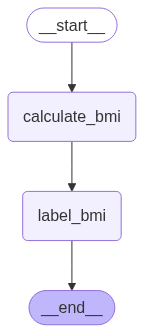

In [15]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

# Sequential Workflow With LLM

In [16]:
!pip install langchain langchain-community langchain-huggingface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.1 MB/s eta 0:00:00


In [17]:
import os
from getpass import getpass

os.environ["HUGGINGFACEHUB_ACCESS_TOKEN"] = getpass("Enter your secret: ")

Enter your secret: ··········


In [25]:
# Define the model
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint

llm = HuggingFaceEndpoint(
    repo_id="deepseek-ai/DeepSeek-R1",
    task="text-generation",
    huggingfacehub_api_token=os.environ["HUGGINGFACEHUB_ACCESS_TOKEN"],
)

model = ChatHuggingFace(llm=llm)

## Define State

In [28]:
# create a state

class LLMState(TypedDict):

    question: str
    answer: str
    summary: str

In [30]:
def llm_qa(state: LLMState) -> LLMState:

    # extract the question from state
    question = state['question']

    # form a prompt
    prompt = f'Answer the following question {question}'

    # ask that question to the LLM
    answer = model.invoke(prompt).content

    # update the answer in the state
    state['answer'] = answer

    return state



In [29]:
def summarize_qa(state:LLMState) -> LLMState:
  # Extract the answer from the state
  answer = state['answer']

  # Form a prompt
  prompt = f'Summarize the following answer {answer} like you explain it to a 10 year old'

  # Ask that question to the LLM
  summary = model.invoke(prompt).content

  # update the
  state['summary'] = summary

  return state

In [31]:
# Graph
graph = StateGraph(LLMState)

# add nodes
graph.add_node('llm_qa',llm_qa)
graph.add_node('summarize_qa',summarize_qa)

# add edges
graph.add_edge(START,'llm_qa')
graph.add_edge('llm_qa','summarize_qa')
graph.add_edge('summarize_qa',END)

# compile
workflow=graph.compile()

# Execute
intial_state = {'question':'What is the capital of India?'}

final_state = workflow.invoke(intial_state)



In [33]:
print(final_state['summary'])

<think>
Okay, so the user wants me to summarize the answer about the capital of India but in a way that a 10-year-old would understand. Let me start by recalling the main points from the original answer. The capital is New Delhi, which is part of the bigger city called Delhi. It's where the government is, and it became the capital after they moved it from Kolkata when the British were in charge.

Now, simplifying for a 10-year-old: I need to use simple words and avoid complex terms. Maybe say "the government works" instead of "administrative, political center." Also, mention that they should remember the name "New Delhi." Perhaps mention famous buildings like the Parliament to make it relatable. Avoid dates like 1911 since a child might not need that detail. Keep it friendly and engaging. Check if the explanation is clear and not confusing. Make sure to clarify that New Delhi is part of Delhi, so they don't get confused between the two. Add something about it being an important city wh